In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
print('train_images:', train_images.shape)
print('train_labels:', train_labels.shape)

train_images: (60000, 28, 28)
train_labels: (60000,)


In [4]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

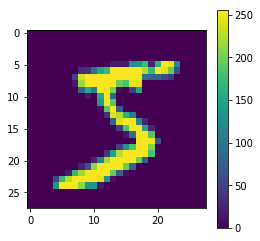

In [5]:
plt.figure(figsize=(4,4))
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

In [6]:
train_images = train_images / 255
test_images = test_images / 255

In [7]:
train_images = train_images.reshape([60000, 28, 28, 1])
test_images = test_images.reshape(10000, 28, 28, 1)

print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
def int2vec(i):
    v = np.zeros([10])
    v[i] = 1
    return v.astype(np.float32)

def vec2int(v):
    return np.argmax(v)

In [9]:
def fc_layer(input, channels_in, channels_out, name='fc'):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([channels_in, channels_out], stddev=0.1), name='W')
        b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name='B')
        
        act = tf.nn.relu(tf.matmul(input, w) + b)
        
        tf.summary.histogram('weights', w)
        tf.summary.histogram('biases', b)
        tf.summary.histogram('activations', act)
        
        return act

In [10]:
EPOCHS = 5
BATCH_SIZE = 100
n_batches = train_images.shape[0] // BATCH_SIZE

# Input images (... then flatten them)
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
tf.summary.image('input', X, 3)

flattened = tf.reshape(X, [-1, 28 * 28])

# Hidden layer: Dense layer of 128 neurons with Relu activation
fc1 = fc_layer(flattened, 28 * 28, 128, name='fc1')

# Output layer: Dense layer of 10 neurons of digit probabilities with Softmax activation
Y_logits = fc_layer(fc1, 128, 10, name='fc2')
Y = tf.nn.softmax(Y_logits)

# Training stuff
Y_ = tf.placeholder(tf.float32, [None, 10], name='Y_')

with tf.name_scope('cross_entropy'):
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_logits, labels=Y_))
    
    tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(0.003).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(Y_logits, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    tf.summary.scalar('accuracy', accuracy)

In [11]:
init = tf.global_variables_initializer()

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter('summary/mnist_playground/')

sess = tf.Session()

sess.run(init)
writer.add_graph(sess.graph)

losses = []
accs = []

for epoch in range(EPOCHS):
    for batch in range(n_batches):
        X_batch = train_images[batch:batch + BATCH_SIZE]
        y_batch = [int2vec(l) for l in train_labels[batch:batch + BATCH_SIZE]]
        
        sess.run(train_step, {X: X_batch, Y_: y_batch})
        
        loss = sess.run(cross_entropy, {X: X_batch, Y_: y_batch})
        losses.append(loss)
        acc = sess.run(accuracy, {X: X_batch, Y_: y_batch}) * 100.0
        accs.append(acc)
        
        s = sess.run(merged_summary, {X: X_batch, Y_: y_batch})
        writer.add_summary(s, epoch * n_batches + batch)
        
    # Print loss and accuracy (on first batch)
    avrg_loss = np.array(losses[epoch * BATCH_SIZE:(epoch + 1) * BATCH_SIZE]).mean()
    avrg_acc = np.array(accs[epoch * BATCH_SIZE:(epoch + 1) * BATCH_SIZE]).mean()
    print('Epoch {:02d} -> loss: {:.4f} accuracy: {:2.1f}%'.format(epoch + 1, avrg_loss, avrg_acc))

Epoch 01 -> loss: 0.4252 accuracy: 85.0%
Epoch 02 -> loss: 0.3379 accuracy: 85.9%
Epoch 03 -> loss: 0.3427 accuracy: 85.5%
Epoch 04 -> loss: 0.2873 accuracy: 87.9%
Epoch 05 -> loss: 0.2365 accuracy: 90.3%


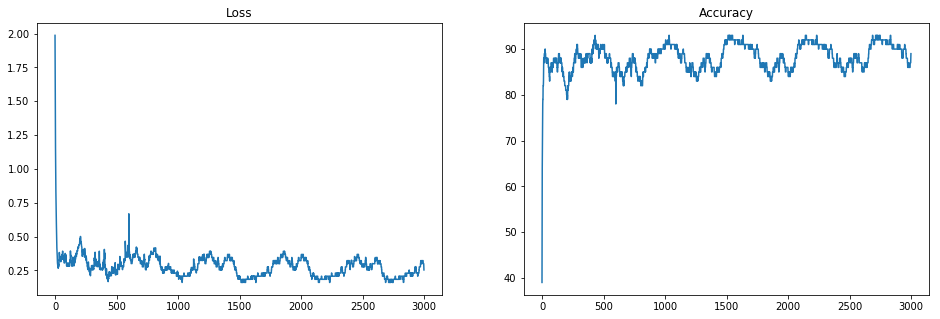

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(losses)
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(accs)

In [13]:
test_accuracy = sess.run(accuracy, {X: test_images, Y_:[int2vec(l) for l in test_labels]})
print(test_accuracy)

0.7768


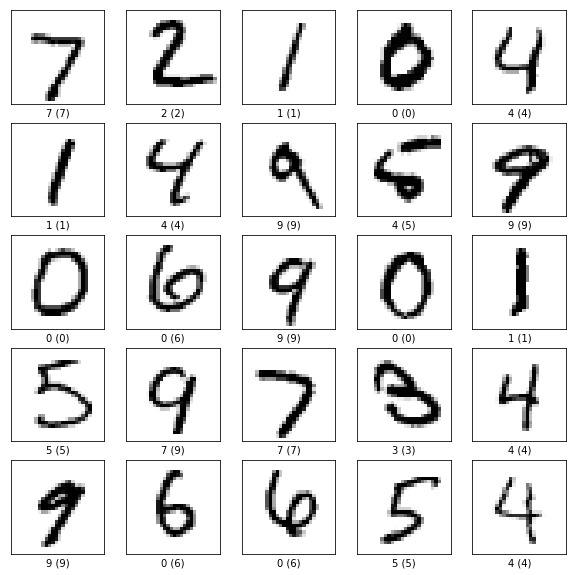

In [14]:
predictions = sess.run(Y, {X: test_images[0:25], Y_:[int2vec(l) for l in test_labels[0:25]]})

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].reshape([28, 28]), cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions[i])
    true_label = test_labels[i]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel('{} ({})'.format(predicted_label, true_label, color=color))